<a href="https://colab.research.google.com/github/james-hughes1/climate-news-NLP/blob/main/Climate_News_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This is the third in a series of programming projects that I have done on the topic of climate change. The first two were specific to the topic of heatwaves in the UK, following the extreme heat witnessed in the UK in the summer of 2022. Find out more at [this link](https://github.com/james-hughes1). This third project follows on with a wider scope. In particular, in the previous project on wildfires I concluded that the classification model could have been improved with a larger and more general dataset. This motivated me to try to use a web scraping library for another coding project. In addition I wanted to switch from a computer vision task to a NLP task in order to learn something new. Hence I have produced this Google Colab notebook.

In this project my objectives were:
1. Scrape news articles from a range of websites, in order to build a dataset of sample sentences, and target labels; specifically whether or not the sentence came from an article on the subject of climate change.
2. Explore some basic natural language processing model features in tensorflow, including tokenisation, word embeddings, and recurrent neural networks (RNNs).
3. Use the tuned model to, given a url for a news article, highlight the parts ascertaining most to the topic of climate change.

The web scraping in the first section is quite time-consuming, and can be skipped if the .csv file in the GitHub repository is downloaded into the current directory.

## Web Scraping: Online News Sites

In this section of code we use the newspaper3k library to scrape news websites for today's articles, and save the article texts in a .csv format. The difficult part is classifying whether or not the article is climate change related, which is slightly different based on how each newspaper builds its articles in html. At the end we can choose whether to create a new .csv file or append to an existing one in the current directory.

In [ ]:
# Import Libraries.

import newspaper
from newspaper.article import ArticleException
from newspaper import Article
import pandas as pd

In [8]:
# Install newspaper3k web scraper.

!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 15.4 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 7.4 MB 42.5 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13553 sha256=0aab8324095325ab76879ced2ffb0b22f8cd3d2f5f0cfe1c81dd7c13d90d7c14
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3357 sha256=c04cc8910e52f8d7e09c255c26fdbde2a1643ce04756046ef87db13c12283cba
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398404 sha256=673117b7ea1aa8e896d496aecf5aa8c02587986f0b217b56

In [9]:
# Run this cell ONCE. It builds the newspaper objects for each website.
# On each execution it only scrapes new articles, so running a second time will ignore almost all articles.

sky_paper = newspaper.build('https://news.sky.com/')
alj_paper = newspaper.build('https://www.aljazeera.com/')
sci_paper = newspaper.build('https://www.sciencedaily.com/')
cli_paper = newspaper.build('https://www.climatechangenews.com/')
cli_paper_2 = newspaper.build('https://insideclimatenews.org/')

CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://components.news.sky.com/
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://news.sky.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://news.sky.com/rss
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://news.sky.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://www.aljazeera.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://www.aljazeera.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://www.sciencedaily.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://www.sciencedaily.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://www.climatechangenew

In [17]:
# Collect article texts and climate labels.

texts = []
climate = []

climatepage = Article('https://news.sky.com/climate')
climatepage.download()
climatefrontpage = climatepage.html.split('Most Read')[0]

for article in sky_paper.articles:
    if 'https://news.sky.com/story/' in article.url:
        article.download()
        try:
            article.parse()
            texts.append(article.text)
            urltitle = article.url[27:]
            climate.append(1*(urltitle in climatefrontpage))
        except ArticleException:
            print(article.url, 'failed to load.')

for article in alj_paper.articles:
    article.download()
    art_html = article.html
    if 'name="keywords" content="' in art_html and '<html class="no-js" lang="en">' in art_html:
        try:
            article.parse()
            texts.append(article.text)
            keywords_str = art_html.split('name="keywords" content="')[1].split('"')[0]
            climate.append(1 * any(['Climate Crisis' in keywords_str,
                                    'Environment' in keywords_str,
                                    'Renewable Energy' in keywords_str]))
        except ArticleException:
            print(article.url, 'failed to load.')

for article in sci_paper.articles:
    article.download()
    art_html = article.html
    if '<meta name="keywords" content="' in art_html and 'html lang="en"' in art_html:
        try:
            article.parse()
            texts.append(article.text)
            keywords_str = art_html.split('<meta name="keywords" content="')[1].split('"')[0]
            climate.append(1 * ('Global Warming' in keywords_str))
        except ArticleException:
            print(article.url, 'failed to load.')

for article in cli_paper.articles:
    article.download()
    try:
        article.parse()
        texts.append(article.text)
        climate.append(1)
    except ArticleException:
        print(article.url, 'failed to load.')

for article in cli_paper_2.articles:
    article.download()
    try:
        article.parse()
        texts.append(article.text)
        climate.append(1)
    except ArticleException:
        print(article.url, 'failed to load.')

https://news.sky.com/story/pakistan-minister-says-west-has-responsibility-to-help-with-floods-as-its-caused-climate-change-12685003 failed to load.


In [33]:
# Save or append data to existing .csv file.

def save_scrape(append_to = None):
    climate_news = pd.DataFrame()
    climate_news['text'] = texts
    climate_news['climate_label'] = climate

    if append_to is not None:
        climate_news_old = pd.read_csv(append_to, usecols=['text','climate_label'])
        climate_news = pd.concat([climate_news_old, climate_news])

    climate_news.to_csv(pd.to_datetime('today').strftime('climate-news-%d-%m-%Y.csv'))

In [34]:
save_scrape('climate_news.csv')

## Importing the Data

In [ ]:
# Import libraries.

import pandas as pd
import re

In [35]:
# Import data as pandas DataFrame.

filename = 'climate-news-20-09-2022.csv'
climate_news = pd.read_csv(filename, usecols=['text','climate_label'])

# Use regex to create list of cleaned sentences present in each article.

sentences = []
labels = []

for i in range(climate_news.shape[0]):
  row = climate_news.iloc[i]
  for j, sentence_raw in enumerate(re.split('[!\?\.][^0-9a-zA-Z]', row[0])):             
    sentence = re.sub('(^[^0-9a-z]*)?([^0-9a-z]*$)?','',
                      re.sub('[^0-9a-z]* [^0-9a-z]*', ' ', sentence_raw.lower()))
    if sentence != '':
      sentences.append(sentence)
      labels.append(row[1])

## Exploration of Data

In [ ]:
# Import libraries.

import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [43]:
# Summary of number of sentences and class balance.

print("Number of sentences is: {}.".format(len(sentences)))
print("Number of climate change related sentences is: {} (or {:.1f}%).".format(sum(labels),100*sum(labels)/len(sentences)))

Number of sentences is: 56457.
Number of climate change related sentences is: 11989 (or 21.2%).


In [52]:
# Sample sentences from each class.

print('Sample of 5 sentences from articles on the topic of climate change:\n  1.{}\n  2.{}\n  3.{}\n  4.{}\n  5.{}'.format(
    *random.sample([sentences[i].strip() for i in range(len(sentences)) if labels[i]==1], 5)))

print('Sample of 5 sentences from articles on other topics:\n  1.{}\n  2.{}\n  3.{}\n  4.{}\n  5.{}'.format(
    *random.sample([sentences[i].strip() for i in range(len(sentences)) if labels[i]==0], 5)))

Sample of 5 sentences from articles on the topic of climate change:
  1.under a pale lavender sky four women walk up to a small house in fiambal a small mountain town in the northern reaches of argentina
  2.in reality his and other governments mended some holes but enlarged others
  3.some 503 fossil fuel representatives attended last year’s cop26 climate talks touting the potential of technologies like biofuels hydrogen and carbon capture to prolong the industry’s relevance
  4.driving in a black gm suv from the township office to the planned construction site along a two-lane state highway yoxheimer the township commission chairman said the township will need to rely on state environmental regulators to make most of the decisions about how the plant will operate
  5.in temperate systems it's difficult to tease the two apart because they're often very synchronized newell said
Sample of 5 sentences from articles on other topics:
  1.the massive aspen stand in south-central utah called

## Train-Test Split & Text Preprocessing

In [53]:
# Shuffle the data.

sentences, labels = zip(*random.sample(list(zip(sentences,labels)), len(sentences)))

# Train-test split.

trainsize = int(len(sentences)*0.8)

train_sentences, train_labels = sentences[:trainsize], labels[:trainsize]
test_sentences, test_labels = sentences[trainsize:], labels[trainsize:]

In [54]:
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 24

# Tokenize text data, converting to integers.

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences to standardise input sequence length.

train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

train_labels = np.array(train_labels).reshape((-1,1))
test_labels = np.array(test_labels).reshape((-1,1))

In [122]:
accuracy_base = 1 - sum(test_labels)/len(test_labels)
print('Baseline accuracy based on test data class imbalance: {:.2f}%'.format(100*float(accuracy_base)))

Baseline accuracy based on test data class imbalance: 78.36%


## Model Training

In [ ]:
# Import libraries

import matplotlib.pyplot as plt

In [56]:
# Learning curve plot function.

def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('binary cross-entropy')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

In [57]:
# Compile model.
embedding_dim = 16

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics='accuracy')

# Display model architecture.
model_1.summary()

# Train model.
history_1 = model_1.fit(train_padded, train_labels,
                    verbose=2,
                    epochs=30,
                    validation_data=(test_padded, test_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 320,017
Trainable params: 320,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1412/1412 - 5s - loss: 0.4636 - accuracy: 0.7941 - val_loss: 0.3832 - val_accuracy: 0.8190 - 5s/epoch - 4ms/step
Epoch 2/30
1412/1412 - 3s - loss: 0.3238 - accuracy: 0.8585 - val_loss: 0.3066 - val_accuracy: 0.8713 - 3s/epoch - 2ms/step


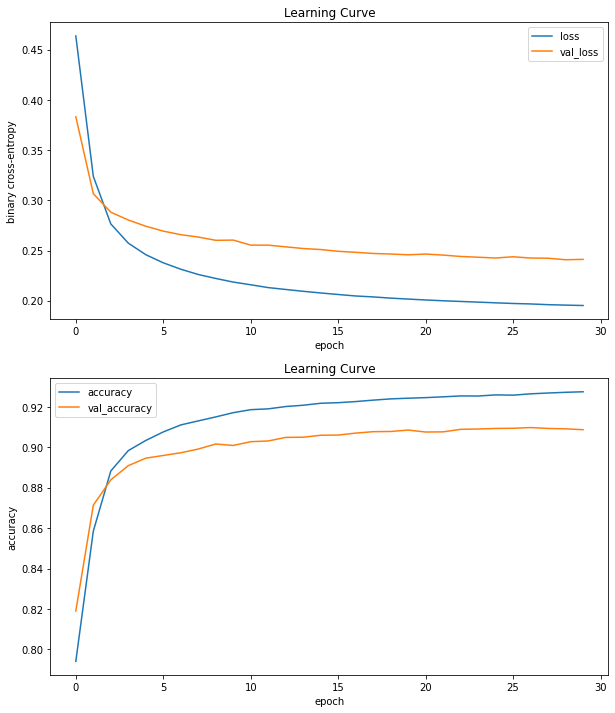

In [58]:
# Plot learning curve.
learning_curve(history_1)

In [59]:
# Compile model.
embedding_dim = 16

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Convolution1D(8, 5),
    tf.keras.layers.AveragePooling1D(8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics='accuracy')

# Display model architechture.
model_2.summary()

# Train model.
history_2 = model_2.fit(train_padded, train_labels,
                    verbose=2,
                    epochs=30,
                    validation_data=(test_padded, test_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          320000    
                                                                 
 conv1d (Conv1D)             (None, None, 8)           648       
                                                                 
 average_pooling1d (AverageP  (None, None, 8)          0         
 ooling1D)                                                       
                                                                 
 dense_1 (Dense)             (None, None, 1)           9         
                                                                 
Total params: 320,657
Trainable params: 320,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1412/1412 - 6s - loss: 0.4191 - accuracy: 0.8211 - val_loss: 0.3838 - val_accuracy: 0.8398 - 6s/epoch -

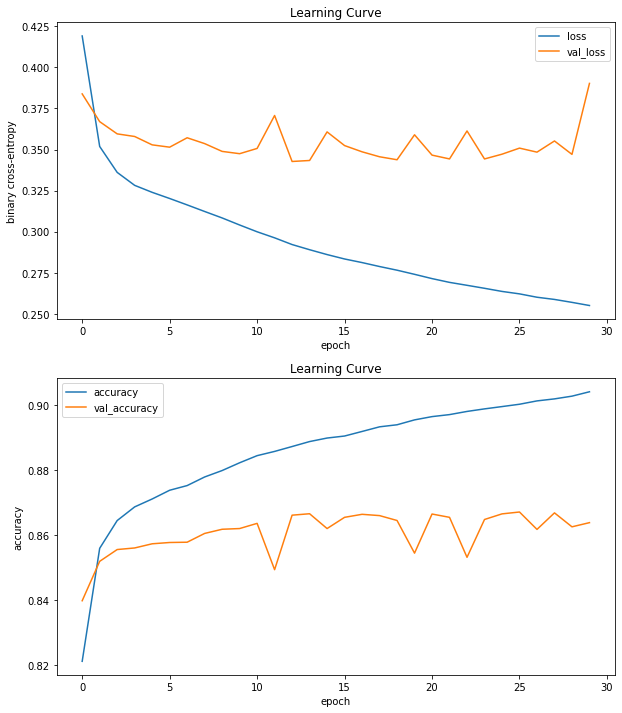

In [60]:
learning_curve(history_2)

In [61]:
# Compile model.
embedding_dim = 16
lstm_units = 4

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(lstm_units),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics='accuracy')

# Display model architecture.
model_3.summary()

# Train model.
history_3 = model_3.fit(train_padded, train_labels,
                    verbose=2,
                    epochs=30,
                    validation_data=(test_padded, test_labels))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          320000    
                                                                 
 lstm (LSTM)                 (None, 4)                 336       
                                                                 
 dense_2 (Dense)             (None, 32)                160       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 320,529
Trainable params: 320,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1412/1412 - 18s - loss: 0.3468 - accuracy: 0.8559 - val_loss: 0.2675 - val_accuracy: 0.8937 - 18s/epoch - 13ms/step
Epoch 2/30
1412/1412 - 15s - loss: 0.2276 - accuracy:

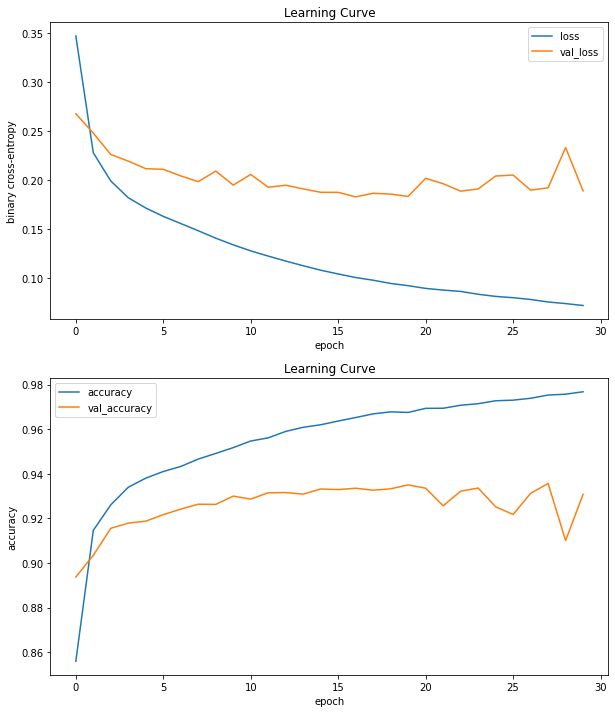

In [62]:
learning_curve(history_3)

In [63]:
# Compile model.
embedding_dim = 8
lstm_units = 4

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(lstm_units),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics='accuracy')

# Display model architecture.
model_4.summary()

# Train model.
history_4 = model_4.fit(train_padded, train_labels,
                    verbose=2,
                    epochs=30,
                    validation_data=(test_padded, test_labels))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense_4 (Dense)             (None, 32)                160       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 160,401
Trainable params: 160,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1412/1412 - 17s - loss: 0.3366 - accu

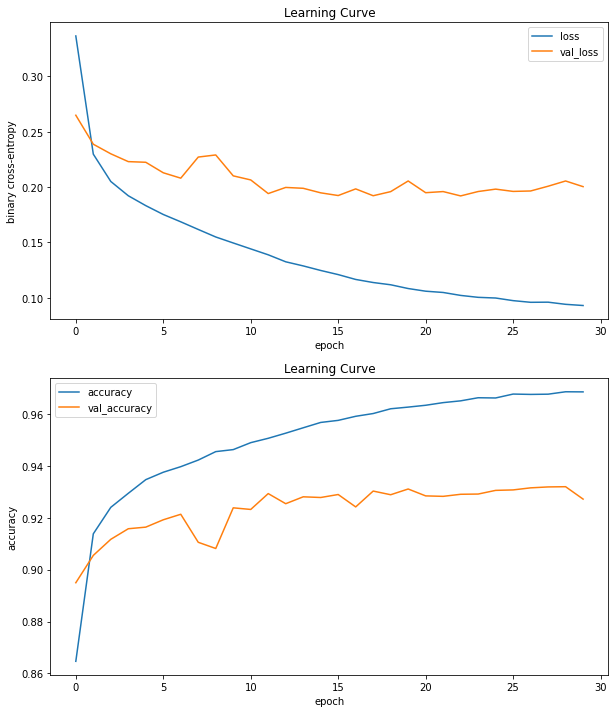

In [64]:
learning_curve(history_4)

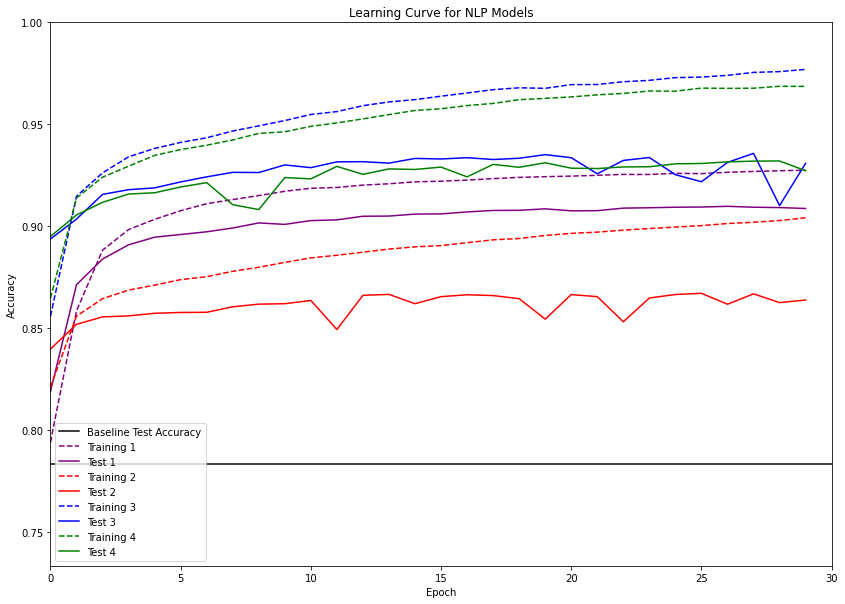

In [69]:
# Plot all learning curves together.
plt.figure(figsize=(14,10))

# Baseline accuracy.
plt.axhline(accuracy_base, label='Baseline Test Accuracy', color='black')

# Learning curves.
plt.plot(history_1.history['accuracy'], label='Training 1', color='purple', linestyle='dashed')
plt.plot(history_1.history['val_accuracy'], label='Test 1', color='purple')
plt.plot(history_2.history['accuracy'], label='Training 2', color='red', linestyle='dashed')
plt.plot(history_2.history['val_accuracy'], label='Test 2', color='red')
plt.plot(history_3.history['accuracy'], label='Training 3', color='blue', linestyle='dashed')
plt.plot(history_3.history['val_accuracy'], label='Test 3', color='blue')
plt.plot(history_4.history['accuracy'], label='Training 4', color='green', linestyle='dashed')
plt.plot(history_4.history['val_accuracy'], label='Test 4', color='green')

# Formatting.
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim((0,30))
plt.ylim((accuracy_base-0.05,1.0))
plt.title('Learning Curve for NLP Models')

plt.show()

We can see that the most basic model, which only used an embedding layer, followed by an average pooling layer acting across the produced text vectors, and then a single sigmoid-activated unit layer, performed well above the baseline accuracy, with a final test accuracy of 90%. This demonstrates the power of text embedding as a concept. This network essentially creates a map of the sentiment of all words in the training data (or at least the 20000 most frequent words) and then classifies a given sentence based on the 'average' word sentiment.

In the second model we replaced the global average pooling layer with a convolutional layer and a stride-based average pooling layer. This is similar to the previous model except it preserves some of the sequential structure of the sentence. But this appeared to perform much worse with a test accuracy of 86%.

The first model was improved upon by replacing the global average pooling layer with a LSTM layer, making the network recurrent. This model also creates a vector map of the word sentiment, but also considers the ordering of the words, and in particular, can relate words in one part of the sentence to important information appearing much earlier in the sentence. It managed to attain a test accuracy in excess of 93% at its peak.

Adding a dropout layer to this model does help in making the learning curve more stable towards the the last few epochs, but ultimately fails in making it more generalised. It appears that the most accurate model was the third, but we should only train it for 15 epochs to avoid overfitting.

In [71]:
# Compile and train final model.
embedding_dim = 16
lstm_units = 4

model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.LSTM(lstm_units),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics='accuracy')

model_5.summary()

history_5 = model_5.fit(train_padded, train_labels,
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, test_labels))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          320000    
                                                                 
 lstm_3 (LSTM)               (None, 4)                 336       
                                                                 
 dense_8 (Dense)             (None, 32)                160       
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 320,529
Trainable params: 320,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1412/1412 - 20s - loss: 0.3351 - accuracy: 0.8618 - val_loss: 0.2670 - val_accuracy: 0.8931 - 20s/epoch - 14ms/step
Epoch 2/15
1412/1412 - 17s - loss: 0.2224 - accuracy:

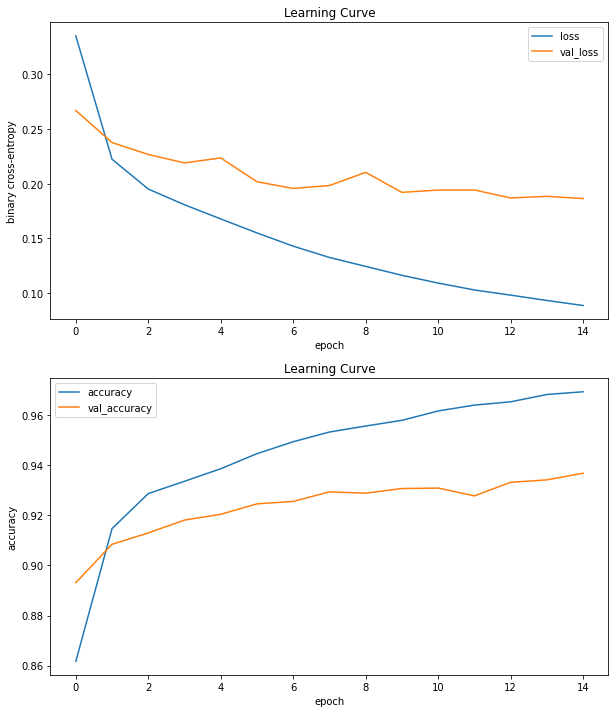

In [72]:
learning_curve(history_5)

## Summarising an External News Article using the Model

We will now create a function `summary_article` which takes a news article url and uses our chosen model to detect the 5 sentences msot relevant to the topic of climate change, regardless of the overall context of the article. This represents a basic prototype of how such a NLP model could be deployed in the real world.

In [ ]:
# Only run if necessary.
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 30.2 MB/s 
     |████████████████████████████████| 7.4 MB 27.9 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 81 kB 11.0 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13553 sha256=d9ec79eaf7fff9bbc10dabe3bea3be904409cc63c57691312767ca6622297278
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3357 sha256=f66c521eabdd2948d61f1a4e42f08b714a695f413fc9200c84457ab31d13ed5a
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398404 sha256=2eba786fe13da85e9b5fbcc2e3578e879544264e68bbeb6

In [ ]:
# Import libraries.

import newspaper
from newspaper import Article

In [118]:
# Summarise article function.

def summary_article(article_url, model):
    # Download and parse article text.
    article = Article(article_url)

    article.download()
    article.parse()

    article_text = article.text

    # Create list of sentences within article.
    sentences_cleaned = []
    sentences_original = []

    for sentence_raw in re.split('[!\?\.][^0-9a-zA-Z]', article_text):
        sentence = re.sub('(^[^0-9a-z]*)?([^0-9a-z]*$)?','',
                            re.sub('[^0-9a-z]* [^0-9a-z]*', ' ', sentence_raw.lower()))
        if sentence != '':
            sentences_original.append(re.sub('\n','',sentence_raw))
            sentences_cleaned.append(sentence)

    # Apply model to list of sentences.
    labels_pred = model.predict(pad_sequences(tokenizer.texts_to_sequences(sentences_cleaned), maxlen=max_length))
    sentences_pred = list(zip(sentences_original, sentences_cleaned, labels_pred,))

    # Sort sentences by model predictions and store top 5.
    sentences_pred.sort(key= lambda x:x[2], reverse=True)
    climate_sentences = [x[0] for x in sentences_pred[:5]]

    # Output.
    print('Highlights from the article relating to climate change:\n  1. {}.\n  2. {}.\n  3. {}.\n  4. {}.\n  5. {}.'.format(
        *climate_sentences))

In [119]:
summary_article('https://www.theguardian.com/environment/2022/sep/20/energy-saving-measures-could-boost-uk-economy-by-7bn-a-year-study-says', model_5)

Highlights from the article relating to climate change:
  1. Insulation rates have been low for the last decade, and the UK has continued to build new homes that use gas boilers, lack solar panels and are not built to low-carbon standards, so will require expensive retrofits to meet the target of net zero greenhouse gas emissions by 2050.
  2. According to the study, the investment required from the government for a scheme to subsidise insulation and install heat pumps would amount to about £27.7bn in total from 2022 to 2030.
  3. It will provide tens of millions of households with warmer homes that are cheaper to run and help limit the catastrophic impacts of the climate crisis.
  4. Parr said: “Greening the UK’s homes at speed and scale will reduce energy consumption, bills and carbon emissions.
  5. According to the modelling used in the report, in 2030 the government would need to spend £4.2bn on supporting heat pumps and insulation, with households spending £9.3bn.


Compare the results of the above 'summary' function with the actual article.

## Conclusion

This project was more difficult than the previous computer vision task. In this project I chose to gather my own dataset using a web scraping library, rather than using the Kaggle API in python. This was a messy process, and I would have liked to source data from more major news websites if I could get the newspaper3k library to work for them. For instance I could not seem to successfully scrape BBC News, The Guardian and so on. Additionally I could not find a standard way to classify each article which would be an obstacle to scaling this process up.

However, with the data that I gathered, I managed to successfully use a variety of NLP analysis techniques to build accurate classification models on the text data. The range of techniques attained varying success but ultimately the simple RNN model structure resulted in the most accurate model, out of those I tried.

I also managed to demonstrate a possible use case for such a machine learning model at the end. This was extremely basic - the next step would be productionisation and deployment, for instance in the browser using Tensorflow.js.

The challenges of the project were a great chance to learn about all of the topics mentioned above. It also refreshed my memory on some more basic python features such as string handling and regex functions.